In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pandas as pd
import csv
from math import sqrt
from math import log
import scipy.optimize as opt
import scipy.special as sp


pd.options.mode.chained_assignment = None

# What are we testing?

The theorethical model I am testing predict that the events comes from 
the center of the Sun, so we will narrow our searches by looking at the events that only <mark style="font-weight:bold">comes from the Sun direction</mark>.

Furthermore, the events we are looking for have a special features, they are the only one that can go through matter without being stopped, so we will narrow our searches even more by looking at events that <mark style="font-weight:bold">comes from the bottom of the Earth and go up</mark>.

<img src="Desktop/thesisPhd/figures/SunAnn_earth.png">

This is how <span style="font-weight:bold">0.0005 s</span> of data looks like in our detector.

In 24h there are 10 billions events.

<img src="Desktop/thesisPhd/figures/Example_eventdisplay.png">

# How do we find upward-going events?


We use Simulation of Cosmic ray tracks to simulate the downward going hypothesis and Dark Matter tracks to simulate the upward going hypothesis.


First we define a set of functions that we will use in the analysis.

We start with choosing a view, that could either be XZ or YZ

In [2]:
def Choose_view(dataframe, View_XZ):
    """
    dataframe        :   type<array_like>
    View_XZ          :   type<bool>
    
    Chose dataframe and if you want XZ view
    and returns a dataframe with only the variable we will use .
    
    """
    if View_XZ is True:
        View = dataframe[['Energy','X','Y','Z','HitTime']][dataframe['View'] == 0]
        return View
    else:
        View = dataframe[['Energy','X','Y','Z','HitTime']][dataframe['View'] == 1]
        return View

To study the behavior of upward going vs downward going tracks, we costruct a 2D plot with a indipendent and dependent variables for each hit in the tracks (each row in the dataframe).


Starting from that, we look at the behaviour of two variables to gain some insight of our data. The indipendent variable is 
<span style="background-color: #FFFF00">observed time</span> (the time registered by the detector when the events happens), the dependent variable is the <span style="background-color: #FFFF00"> expected time </span> (distance that the particles travel divided by the speed of light)


Start by taking the hit that happened at the lowest and highest point in the XZ or YZ view (corresponding to the initial and the final point in the list or dataframe column).

In [3]:
def Get_variables(dataframe):
    """
    dataframe           :   type<pd.dataframe>  
    
    For a dataframe and returns the value of the first and last point in X, Y, Z direction.

    """
    #Start and End point correspond to the first and last point of the 
    # dataframe's column
    x_start  = dataframe['X'].iloc[0]
    x_end    = dataframe['X'].iloc[-1]
    y_start  = dataframe['Y'].iloc[0]
    y_end    = dataframe['Y'].iloc[-1]
    z_start  = dataframe['Z'].iloc[0]
    z_end    = dataframe['Z'].iloc[-1]
    
    return x_start, x_end, y_start, y_end, z_start, z_end 

The assumption we are making is:

<mark style="font-weight:bold" style="color:red">All the tracks are moving upward.</mark>

In the 2D plot we are constructing the tracks will behave in opposite way. (Have opposite slope) 



<img src="Desktop/Python/Expected_vs_Observed_time.png">

With this information we can calculate the expectated time:

In [4]:
def Calculate_expectation(dataframe, x_start, x_end, y_start, y_end, z_start, z_end):
    """
    dataframe           :   type<pd.dataframe>
    x_start, x_end      :   type<float>   
    
    Takes the dataframe and the x, y, z start and end points and
    returns a new column with 
    the expected time for each point
    
    """  
    distance           = sqrt( ( x_start - x_end )**2 + ( y_start - y_end )**2 + ( z_start - z_end)**2 )
    TimeOfFlight       = distance / 29.97 #light speed in cm/ns
    TimeOfFlight_ratio = TimeOfFlight / ( x_end - x_start )
    #add a column where for each point calculate the expected time 
    #based on the x (or y) position of the point
    dataframe['Expected time'] = dataframe['X'].apply( lambda x : TimeOfFlight_ratio * (x - x_start) )
    
    return dataframe['Expected time']

The error on each point depends on it's energy value, through a function studied in a previuos work. A different function will be applied in case we are using simulation or real data.

In [5]:
def getErr(Energy, Simulation):
    """
    dataframe        :   type<array_like>
    Simulation       :   type<bool>
    
    Takes the Energy value and if the data are simulated.
    Returns the error associated with each point
    
    """
    if Simulation is True:
        return 163551 / (1847.39 + pow( Energy, 2.10082)) + 8.65312
    else:
        return 165143 / (1882.9 + pow( Energy, 2.11447)) + 10.4321

Each expected time's point will have an error associated to it, depending on the energy of the point.
The more energetic it is, the more light it releases, the better the identification and smaller the error.

In [6]:
def Calculate_expectation_error(dataframe, Simulation):
    """
    dataframe          :   type<pd.dataframe>
    Simulation         :   type<bool>    
    
    Takes a dataframe and if it is Simulated data
    returns a list with the errors associated to each point in the dataframe.
    
    """
    #add a column where for each point calculate the expected time 
    #based on the Energy of the point
    dataframe['Expected time error'] = dataframe['Energy'].apply(lambda x : getErr(x,Simulation) )
    #pass it to a list 
    errors_list =  dataframe['Expected time error'].tolist()
    
    return errors_list

# Now that we have made the 2D plot, do the events agree with the assumption?

There is a linear correlation between the indipendent variable (The observed time) and the dependent variable (The expected time) in this case, so we'll try to fit the point with a linear predictor function.

In this case, we'll have to also take into account that each point has a specific error associated, so we will use the scipy curve_fit option to find the best fit line to a collection of points in 2D

The linear predictor function:

In [7]:
def func(x, slope, intercept):
    """
    x           :   type<list> or type<array>
    slope       :   type<float>
    intercept   :   type<float>
    Takes an array and a value for the slope and intercept
    and return a line
    """
    return slope * x + intercept

First we have to pass a guessed value for the slope and the intercept.
In first approximation the slope and the intercept can be calculated using the first and the last point in the plot

In [8]:
def guess_initial_parameters(xs, ys):
    """
    xs          :   type<list> or type<array>
    ys          :   type<list> or type<array>
    
    Takes two array and returns a first approx value for the slope and intercept
    """
    ##guess the slope
    slope = (ys[-1]-ys[0])/(xs[-1]-xs[0])
    alpha = 1/slope
    ##guess the intercept
    intercept = np.mean([ys[-1] - xs[-1]/alpha, ys[0] - xs[0]/alpha])
    
    print('The initial guess for the slope is: '+ str(slope) )
    
    return [alpha, intercept]

We are now ready to plot the variables and fit them.

In [9]:
def Make_Plot(dataframe, name , error_list):
    """
    dataframe          :   type<pd.dataframe>
    name               :   type<string>    
    error_list         :   type<list>
    
    Takes a dataframe, a name for the plot, and the error associated with the expectation
    returns a plot of observed vs expected time fitted by a weighted line.
    
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    #indipendent variable
    x = dataframe['HitTime']
    #dependent variable
    y = dataframe['Expected time']
   
    #initial guess for slope and intercept parameters  
    slope, intercept = guess_initial_parameters(dataframe['HitTime'].tolist(), dataframe['Expected time'].tolist())
    #fit the 2D point with a linear function
    popt, pcov = opt.curve_fit(func, x, y, p0=(slope, intercept), sigma=error_list)
    #use the estimated parameters to best fit line
    line = popt[0] * dataframe['HitTime'] + popt[1]

    plt.title("Observed vs Expected time " + name)
    plt.xlabel("T_obs (ns)")
    plt.ylabel("T_exp (ns)")
    
    #plot the x and y variables plus the error
    plt.errorbar(dataframe['HitTime'], dataframe['Expected time'], yerr = error_list, ecolor = 'blue', fmt = 'o', marker = 's', mfc = 'green', mec = 'green', ms = 3, mew = 3)
     #plot the best fit line
    plt.plot(dataframe['HitTime'], line, label = "fit", color = 'red');
 
    print('The slope value for the '+ name +' hypothesis is = '+ str(popt[0]) )
    
    return plt.show()

# Some more testing...

We can define the Chi2 calculation with two fixed slope +1 and -1 (representing upward and downward going) to get an idea about the probability that the track is an upward going one:

In [10]:
def Chi2_def(x, y, ey):
    """
    x           :   type<list> or type<array>
    y           :   type<list> or type<array>
    ey          :   type<list> or type<array>
    
    Takes x and y array and the error associated with the expectation
    returns the Chi2/ndof and probability associated with the upward or downward going hypothesis
    
    """
    ## Before going ahead, make sure we have sensible arrays
    assert(len(x) == len(y))
    assert(len(x) == len(ey))
    assert(len(ey) >= 2)

    ## Define the sums needed for the calculation:
    s   = 0.0
    sx  = 0.0
    sxx = 0.0
    sy  = 0.0
    sxy = 0.0
    syy = 0.0
    n = len(x)
    
   ## Loop over data to calculate relevant sums:
    for i in range(n) :
        e    = float(ey[i]) 
        s   += 1.0 / (e**2)
        sx  += float(x[i]) / (e**2)
        sy  += float(y[i]) / (e**2)

    up_intercept = (sy - sx) / s
    dn_intercept = (sy + sx) / s
    
    ## So now you have data points and a fit/theory. How to get the fit quality?
    ## The answer is to calculate the Chi2 and Ndof, and from them get their
    ## probability using a function 
    Chi2_calc_up = 0.0
    Chi2_calc_dn = 0.0
    for i in range(n) : 
        e = float(ey[i])
        fit_value_up = up_intercept + x[i]
        fit_value_dn = dn_intercept - x[i]
        Chi2_calc_up += ((y[i] - fit_value_up) / e)**2.0
        Chi2_calc_dn += ((y[i] - fit_value_dn) / e)**2.0
  
    ## Number of variables (slope and intercept)
    Nvar = 2       
    ## Number of degrees of freedom
    Ndof_calc = n - Nvar   

    ## From Chi2 and Ndof, one can calculate the probability of obtaining this
    ## or something worse (i.e. higher Chi2).Regularized upper incomplete gamma function
    ## The returned probability corresponds to 1-P(a,x), 
    ## which denotes the probability that an observed Chi-squared exceeds the value chi2 by chance, 
    #even for a correct model

    Prob_calc_up = sp.gammaincc( (Ndof_calc) / 2.0, Chi2_calc_up / 2.0)
    Prob_calc_dn = sp.gammaincc( (Ndof_calc) / 2.0, Chi2_calc_dn / 2.0)
     
    if (Prob_calc_up < 1e-30):
        Prob_calc_up = 1e-30
    if (Prob_calc_dn < 1e-30):
        Prob_calc_dn = 1e-30
        
    print ('The goodness of the fit for the upward-going hypothesis = ' + str( Chi2_calc_up / (n-2) ) )
    print ('The goodness of the fit for the down-going hypothesis = ' + str( Chi2_calc_dn / (n-2) ) )
    
    return Prob_calc_up, Chi2_calc_up / (Ndof_calc), Prob_calc_dn, Chi2_calc_dn / (Ndof_calc)

The likelihood helps us to respond the question: how likely is the data, given the parameters?

With the probability of upward or downward going hypothesis
we can construct a Likelihood ratio. 
Likelihood ratios provide a numerical measure of the effect of a result on probability, 
and we take the logarithm of its for simplicity

In [11]:
def Get_log_likelihood_ratio(dataframe, errors_list):
    """
    dataframe          :   type<pd.dataframe>
    error_list         :   type<list> 
    
    Takes a dataframe and the error list,
    returns the log likelihood ratio for the upward or downward going hypothesis
    
    """
    xlist = dataframe['HitTime'].tolist()
    ylist = dataframe['Expected time'].tolist()

    Prob_upward_going, Chi2_upward_going, Prob_downward_going, Chi2_downward_going = Chi2_def(xlist, ylist, errors_list)
    #Likelihood ratios provide a numerical measure of the effect of a result on probability
    #LR= Positive probability  / Negative probability
    LLR = log(Prob_upward_going / Prob_downward_going)
    
    return print ('The log Likelihood ratio value for the upward-going hypothesis is = ' + str(LLR))

# Let's check if this works with simulated models first

In [12]:
#SIGNAL
col = [x for x in range(0,32) if x % 2 == 1]
SIG = pd.read_csv('Desktop/Python/Wimps_2hits_new.txt',usecols=col,delimiter=' ',header=None)
SIG.columns=['Energy','Min Energy','GeV','X','Y','Z','HitTime','View','ID','Plane','Cell','Channel','Digital time','TNS','ADC','PE']
SIG.head()

,Energy,Min Energy,GeV,X,Y,Z,HitTime,View,ID,Plane,Cell,Channel,Digital time,TNS,ADC,PE
0,217.72,0.93,0.01,-178.93,39.67,5160.73,-1.38,0,0,773,146,537662610,14452,224547.84,227,83.39
1,268.63,1.15,0.01,-177.77,49.22,5154.00,-17.23,1,0,772,204,537661644,14424,224546.39,196,73.53
2,483.66,2.06,0.02,-196.98,60.35,5147.43,-24.91,0,0,771,142,537660558,14452,224521.97,467,172.91
3,363.29,1.55,0.02,-172.50,60.35,5147.43,-17.61,0,0,771,148,537660564,14436,224530.77,332,125.53
4,139.39,0.59,0.01,-200.88,60.35,5147.43,-2.19,0,0,771,141,537660557,14460,224544.44,143,52.13


The initial guess for the slope is: 0.9098693570776614
The slope value for the Signal hypothesis is = 0.5032503872490471


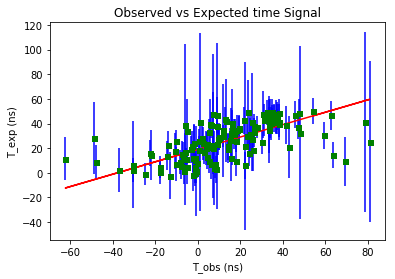

The goodness of the fit for the upward-going hypothesis = 1.5613161476872235
The goodness of the fit for the down-going hypothesis = 8.051623824091916
The log Likelihood ratio value for the upward-going hypothesis is = 58.80989448516217


In [13]:
Signal = Choose_view(SIG, True)
x_start_s, x_end_s, y_start_s, y_end_s, z_start_s, z_end_s  = Get_variables(Signal)
Signal['Expected time']= Calculate_expectation(Signal, x_start_s, x_end_s, y_start_s, y_end_s, z_start_s, z_end_s)
errors_list_s = Calculate_expectation_error(Signal, True)

%matplotlib inline
Make_Plot(Signal, 'Signal' , errors_list_s)
Get_log_likelihood_ratio(Signal, errors_list_s)

In [14]:
#BACKGROUND
col = [x for x in range(0,32) if x % 2 == 1]
BKG = pd.read_csv('Desktop/Python/Cosmic_1hits_new.txt',usecols=col,delimiter=' ',header=None)
BKG.columns=['Energy','Min Energy','GeV','X','Y','Z','HitTime','View','ID','Plane','Cell','Channel','Digital time','TNS','ADC','PE']


The initial guess for the slope is: -0.9617690760607164
The slope value for the Background hypothesis is = -0.4201272291763769


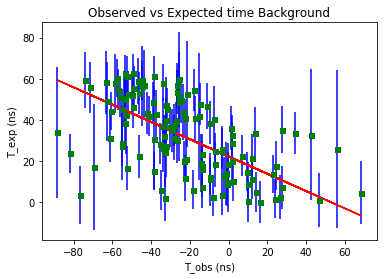

The goodness of the fit for the upward-going hypothesis = 14.235160129591831
The goodness of the fit for the down-going hypothesis = 3.8734941982321796
The log Likelihood ratio value for the upward-going hypothesis is = 0.0


In [15]:
Background = Choose_view(BKG, True)
x_start_b, x_end_b, y_start_b, y_end_b, z_start_b, z_end_b  = Get_variables(Background)
Background['Expected time']= Calculate_expectation(Background, x_start_b, x_end_b, y_start_b, y_end_b, z_start_b, z_end_b)
errors_list_b = Calculate_expectation_error(Background, True)

%matplotlib inline
Make_Plot(Background, 'Background' , errors_list_b)
Get_log_likelihood_ratio(Background, errors_list_b)

# Now we are ready to apply it to our data

In [16]:
# Read in the fil
col = [x for x in range(1,32) if x % 2 == 1]
Data = pd.read_csv('Desktop/Python/DDUPMU_2hits_new.txt',usecols=col,delimiter=' ',header=None,skiprows=1,skipfooter=1,engine='python')
Data .columns=['Energy','Min Energy','GeV','X','Y','Z','HitTime','View','ID','Plane','Cell','Channel','Digital time','TNS','ADC','PE']


The initial guess for the slope is: 0.6493910884748136
The slope value for the selected data hypothesis is = 0.5540769646485197


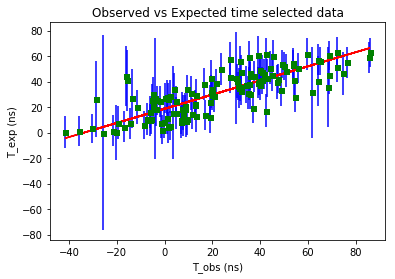

The goodness of the fit for the upward-going hypothesis = 1.5114406190691776
The goodness of the fit for the down-going hypothesis = 11.62098183662577
The log Likelihood ratio value for the upward-going hypothesis is = 60.58543947769874


In [17]:
Data_selected = Choose_view(Data, False)
x_start_data, x_end_data, y_start_data, y_end_data, z_start_data, z_end_data  = Get_variables(Data_selected)
Data_selected['Expected time']= Calculate_expectation(Data_selected, x_start_data, x_end_data, y_start_data, y_end_data, z_start_data, z_end_data)
errors_list_data = Calculate_expectation_error(Data_selected, False)

%matplotlib inline
Make_Plot(Data_selected, 'selected data' , errors_list_data )
Get_log_likelihood_ratio(Data_selected, errors_list_data )


# Are we done? Nope, still a lot of cleaning to do...

So this is how we select our data, but there is still a lot of clening to do. What we do next is to apply a series of strict cuts to the data, to be sure that the final sample is as clean as possible.

For simplicity I will just show a piece of the C++ code I use in my analysis:

<style>
div.warn {    
    background-color: #fcf2f2;
    border-color: #dFb5b4;
    border-left: 5px solid #dfb5b4;
    padding: 0.5em;
    }
 </style>

```c++
for(size_t k=0; k<v.size(); k++)
        {
          const Track &t = v[k];
          Islope->Fill(t._slope);
          //looking for double tracks in the same slice                                                                                                        
          for(size_t i=k+1; i<v.size(); i++)
            {
              diffSS[i] = v[k]._startz - v[i]._startz;
              diffEE[i] = v[k]._endz - v[i]._endz;
              if (fabs(diffSS.at(i)) < 50) matchSS++;
              if (fabs(diffEE.at(i)) < 50) matchEE++;
            }
          // Events with more than one match? Remove it!               
          if (matchSS> 1 || matchEE > 1)       {pass=false; break;}
          // Events not long enough?          Remove it!  
          if (t._length < 700)                 {pass=false; break;}
          pass_cuts[0]++;
          // Events with few hits?            Remove it!   
          if (t._nhits < 70)                   {pass=false; break;}
          pass_cuts[1]++;                                              
          // Events not linear in X view?    Remove it!   
          if (t._r2x < 0.99)                   {pass=false; break;}
          pass_cuts[7]++;
          // Events not linear in Y view?    Remove it!   
          if (t._r2y < 0.99)                   {pass=false; break;}
          // Events with a bad fit?          Remove it!   
          if (t._chi2 > 1.5)                   {pass=false; break;}
          pass_cuts[9]++;
          // Events with low Prob to go up?   Remove it!  
          if (t._llr < 20)                     {pass=false; break;}
        }


```

After this, we are finally left with a clean sample of final events

# Final results... Did we discover Dark Matter?

At the end we compare the distribution of our data with the simulated signal distribution, that show us how Dark Matter would be distributed in  our detector if it would exist.


<span style="color:red" style="font-weight:bold">Did we discover Dark Matter?</span>

<img src="Desktop/Python/bkg_vs_simulation.png">

:( 

Not yet,
 the data don't support the model that we studied